In [102]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def collect_heatmap_data(path: str):
    heatmap = np.zeros((160, 210)) 
    for video_file in tqdm(glob.glob(f"{path}/**/*.mp4", recursive=True), desc="Processing videos"):
        cap = cv2.VideoCapture(video_file)
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            color = [76, 171, 204] ## Average MsPacman color
            lower_yellow = np.array(color) - 20
            upper_yellow = np.array(color) + 20

            mask = cv2.inRange(frame, lower_yellow, upper_yellow)

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, *_ = cv2.boundingRect(largest_contour)

                if y < 170:
                    heatmap[x, y] += 1

        cap.release()
        
    return heatmap


def draw_heatmap(image_path: str, heatmap: np.ndarray):
    img = cv2.imread(image_path)

    heatmap[70:90, 100:110] = 0
    normalized_heatmap = heatmap / heatmap.max()

    for x in range(heatmap.shape[0]): 
        for y in range(heatmap.shape[1]):
            value = normalized_heatmap[x, y]
            if value > 0:
                color = [255, 0, 0]
                center = (x, y)
                radius = 3 
                thickness = -1 

                overlay = img.copy()
                cv2.circle(overlay, center, radius, color, thickness, lineType=cv2.LINE_AA)
                alpha = max(0.01, value) 
                cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [91]:
heatmap = collect_heatmap_data('../checkpoints/muzero_gpu_priorities')

100%|██████████| 1045/1045 [02:04<00:00,  8.40it/s]


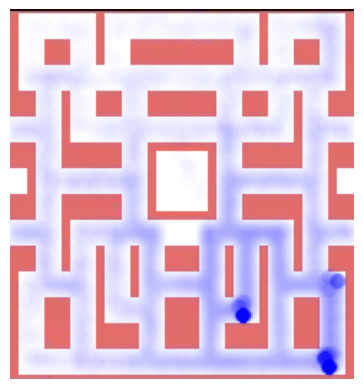

In [106]:
draw_heatmap('plots/white_blank.png', heatmap)
plt.savefig('plots/muzero-heatmap.png', bbox_inches='tight', pad_inches=0)